In [103]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from datetime import datetime

%matplotlib inline

In [104]:
raw_data = pd.read_csv('2007.csv')
list(raw_data.columns)


['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'UniqueCarrier',
 'FlightNum',
 'TailNum',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Origin',
 'Dest',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [105]:
raw_data = raw_data.drop(['Month', 'UniqueCarrier', 'DayOfWeek', 'Origin'], 1)
print(np.where(raw_data['Diverted'] != 0))

(array([   3340,    8000,    8014, ..., 7451634, 7451702, 7452734]),)


In [106]:
# Count nulls 
"""null_count = raw_data.isnull().sum()
null_count[null_count>0]"""

'null_count = raw_data.isnull().sum()\nnull_count[null_count>0]'

In [107]:
#Get rid of flights that were cancelled since they couldn't be late.

df2007 = raw_data[raw_data.CancellationCode.isnull()]

#Get rid of Cancellation code since it comes up only when an aircraft is cancelled. We also won't need Year since it's 2007.
df2007 = df2007.drop(['Year', 'FlightNum', 'TailNum', 'Dest', 'Cancelled', 'Diverted', 'DayofMonth','CancellationCode'], 1)
# Count nulls 
"""null_count = df2007.isnull().sum()
null_count[null_count>0]"""

'null_count = df2007.isnull().sum()\nnull_count[null_count>0]'

In [108]:
#Dropping out cancelled flights got rid of the majority of our nulls. The rest seem to be issues with Arrival time/delay, so let's get rid of them all. 
df2007 = df2007.dropna()
null_count = df2007.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

In [109]:
#Turn this into a classification with the definition that a late plane is one that arrives 30 minutes or more late.
threshold = 30.0
df2007['Late'] = np.where(df2007['ArrDelay'] >= threshold, 1,0)

In [110]:
"""print(df2007['Late'].value_counts())"""

"print(df2007['Late'].value_counts())"

In [111]:
#Rebalance the data
not_late = df2007.loc[np.where(df2007['Late'] == 0)]

# Take a random sample from the not lates
msk = np.random.rand(len(not_late)) < 0.15
not_data = not_late[msk]

df2 = not_data.append(df2007.loc[np.where(df2007['Late'] == 1)])

print(df2['Late'].value_counts())

0.0    1674362
1.0     301169
Name: Late, dtype: int64


In [112]:
null_count = df2.isnull().sum()
null_count[null_count>0]

DepTime              49679
CRSDepTime           49679
ArrTime              49679
CRSArrTime           49679
ActualElapsedTime    49679
CRSElapsedTime       49679
AirTime              49679
ArrDelay             49679
DepDelay             49679
Distance             49679
TaxiIn               49679
TaxiOut              49679
CarrierDelay         49679
WeatherDelay         49679
NASDelay             49679
SecurityDelay        49679
LateAircraftDelay    49679
Late                 49679
dtype: int64

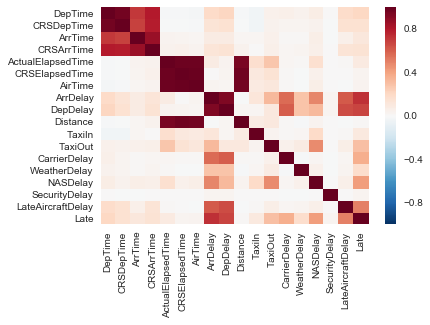

In [113]:
#Turn the string features into dummies
df2007 = pd.get_dummies(df2007)

#See how the independent variables correlate to each other
sns.heatmap(df2007.corr())

In [114]:
m = df2007.isnull().any()
print("========= COLUMNS WITH NULL VALUES =================")
print(m[m])
print("========= COLUMNS WITH INFINITE VALUES =================")
m = np.isfinite(df2007.select_dtypes(include=['float64'])).any()
print(m[m])

========= COLUMNS WITH NULL VALUES =================
Series([], dtype: bool)
========= COLUMNS WITH INFINITE VALUES =================
DepTime              True
ArrTime              True
ActualElapsedTime    True
CRSElapsedTime       True
AirTime              True
ArrDelay             True
DepDelay             True
dtype: bool


In [115]:
#Use Lasso/RFE to get the best features
lr = LogisticRegression(C=1, penalty='l1')

#Set up our X,y
X = df2007.drop(['ArrDelay', 'Late'], 1)
y = df2007['Late']

#Set up our Recursive Feature Elimination
rfe = RFE(lr,n_features_to_select=8) 
fit = rfe.fit(X,y)
result_RFE = pd.DataFrame(list(zip(X.head(0), rfe.ranking_, rfe.support_)),
                          columns=['Features','Ranking','Support'] ) 
print(result_RFE.sort_values('Ranking'))

             Features  Ranking  Support
6             AirTime        1     True
7            DepDelay        1     True
9              TaxiIn        1     True
11       CarrierDelay        1     True
12       WeatherDelay        1     True
13           NASDelay        1     True
14      SecurityDelay        1     True
15  LateAircraftDelay        1     True
4   ActualElapsedTime        2    False
5      CRSElapsedTime        3    False
10            TaxiOut        4    False
3          CRSArrTime        5    False
2             ArrTime        6    False
1          CRSDepTime        7    False
0             DepTime        8    False
8            Distance        9    False
